In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from collections import Counter
from wordcloud import WordCloud # https://github.com/amueller/word_cloud/issues/637

Data used in this analysis was web scraped and extracted by @dekristi https://github.com/dekristi/Spotify_Project/tree/main

### Process playlist and albums data, print column names and head, merge into one dataframe.

In [2]:
df_playlist = pd.read_csv('new_artists_playlist.csv')
df_albums = pd.read_csv('new_artists_albums_data.csv')

In [3]:
print(f'Playlist: {df_playlist.columns}\nAlbums: {df_albums.columns}')

Playlist: Index(['id', 'picture', 'artist', 'hottest', 'streams_b', 'followers_mio',
       'listeners_mio', 'scoring'],
      dtype='object')
Albums: Index(['artist_name', ' album_name', 'release_date', 'total_track'], dtype='object')


In [4]:
df_playlist = df_playlist.drop(['id', 'picture'], axis = 1)

In [5]:
df_albums = df_albums.rename(columns={'artist_name': 'artist', ' album_name': 'album_name'})
df_playlist = df_playlist.rename(columns={'followers_mio': 'followers_mln', 'listeners_mio': 'listeners_mln'})
print(df_albums.head())
print(df_playlist.head())

         artist                        album_name release_date  total_track
0  Taylor Swift      Speak Now (Taylor's Version)   2023-07-07           22
1  Taylor Swift  Midnights (The Til Dawn Edition)   2023-05-26           23
2  Taylor Swift           Midnights (3am Edition)   2022-10-22           20
3  Taylor Swift                         Midnights   2022-10-21           13
4  Taylor Swift            Red (Taylor's Version)   2021-11-12           30
         artist  hottest  streams_b  followers_mln  listeners_mln  scoring
0  Taylor Swift      100      57.92          86.48         100.97      233
1         Drake       95      62.93          79.86          75.33      205
2     Bad Bunny       94      57.97          74.24          74.80      189
3    The Weeknd       94      47.62          71.64         106.92      186
4    Ed Sheeran       87      44.57         115.09          75.72      166


In [6]:
artist_album_counts = df_albums.groupby('artist')['album_name'].count().reset_index()
artist_album_counts.rename(columns={'album_name': 'album_count'}, inplace=True)

In [7]:
df_merged = pd.merge(df_playlist, artist_album_counts, on=['artist'], how='inner')
print(df_merged.shape)
print(df_merged.head())

(945, 7)
         artist  hottest  streams_b  followers_mln  listeners_mln  scoring  \
0  Taylor Swift      100      57.92          86.48         100.97      233   
1         Drake       95      62.93          79.86          75.33      205   
2     Bad Bunny       94      57.97          74.24          74.80      189   
3    The Weeknd       94      47.62          71.64         106.92      186   
4    Ed Sheeran       87      44.57         115.09          75.72      166   

   album_count  
0           24  
1           17  
2            5  
3           15  
4           13  


### Generate summary statistics, count unique artists and albums, and plot correlation matrix and histograms of key features

In [8]:
# Summary Statistics
summary_stats = df_merged.describe()

# Unique Values
unique_artists = df_merged['artist'].nunique()
unique_albums = df_albums['album_name'].nunique()

# print('Summary Statistics:')
print('\nUnique Artists Names in df_merged:', unique_artists)
print('Unique Albums:', unique_albums)

properties = {'border': '3px solid gray', 'color': 'green', 'font-size': '14px'}
summary_stats.style.set_properties(**properties).format(precision=2)


Unique Artists Names in df_merged: 945
Unique Albums: 15165


,hottest,streams_b,followers_mln,listeners_mln,scoring,album_count
count,945.00,945.00,945.00,945.00,945.00,945.00
mean,74.04,5.44,8.49,17.66,17.15,15.99
std,5.71,6.25,11.49,13.59,22.21,38.34
min,61.00,0.52,0.39,2.56,5.00,1.00
25%,70.00,2.33,3.08,9.19,7.00,4.00
50%,73.00,3.40,5.13,13.06,10.00,9.00
75%,77.00,5.86,8.80,21.60,18.00,16.00
max,100.00,62.93,115.09,106.92,233.00,726.00


<Axes: >

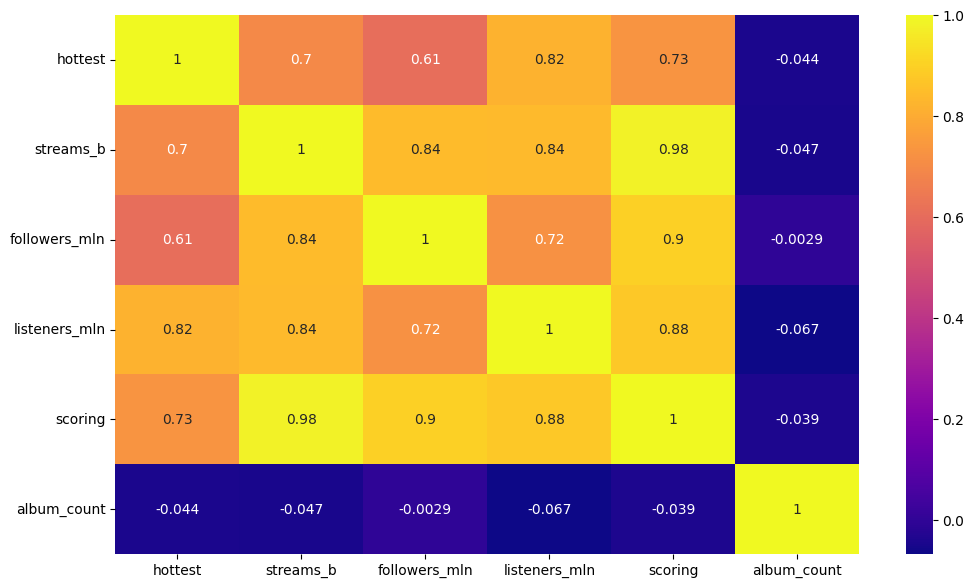

In [9]:
plt.figure(figsize=(12,7))
corr = df_merged.corr(numeric_only=True)
sns.heatmap(corr, cmap='plasma', annot=True)

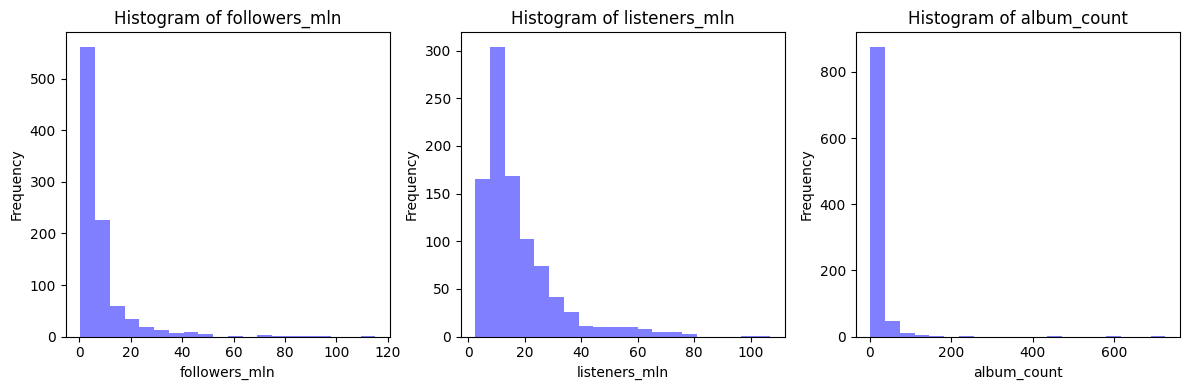

In [10]:
columns_to_plot = ['followers_mln', 'listeners_mln', 'album_count']

# Create subplots for histograms
fig, axes = plt.subplots(nrows=1, ncols=len(columns_to_plot), figsize=(12, 4))

# Create histograms for each column
for i, column in enumerate(columns_to_plot):
    axes[i].hist(df_merged[column], bins=20, alpha=0.5, color='blue')
    axes[i].set_title(f'Histogram of {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

The key findings from the data analysis are:

* There are positive correlations between social connections (followers_mln and listeners_mln), sentiments (hottest and scoring), and sales performance (streams_b).
* The strongest correlation is between streams_b and scoring.
* Album count has a negative correlation with all other variables.

Below are some actionable recommendations based on these findings:

* Build social connections by engaging with fans on social media and other platforms.
* Release fewer albums to avoid fan fatigue and lower social media sentiment.

***

### Categorize artists by followers_mln and listeners_mln, and visualize the distribution of artists by category

In [11]:
# Calculate the mean and standard deviation of 'followers_mln'
mean_followers_mln = df_merged['followers_mln'].mean()
std_followers_mln = df_merged['followers_mln'].std()

# Define a function to categorize 'followers_mln' based on mean and standard deviation
def categorize_followers_mln(followers_mln):
    if followers_mln < (mean_followers_mln - std_followers_mln):
        return 'Low Followers'
    elif (mean_followers_mln - std_followers_mln) <= followers_mln < (mean_followers_mln + std_followers_mln):
        return 'Moderate Followers'
    else:
        return 'High Followers'

# Apply the categorization function to 'followers_mln' column
df_merged['followers_mln_category'] = df_merged['followers_mln'].apply(categorize_followers_mln)

color_scale = ['#0000FF', '#00FF00', '#FF0000']
category_orders_followers_mln = {'followers_mln_category':
                                 ['Low Followers', 'Moderate Followers', 'High Followers']}

# Create a DataFrame with counts for each followers_mln category
followers_mln_category_counts = df_merged['followers_mln_category'].value_counts().reset_index()
followers_mln_category_counts.columns = ['followers_mln_category', 'Artists Count']

# Create a bar chart for the followers_mln_category
followers_mln_category_fig = px.bar(followers_mln_category_counts,
                                x='followers_mln_category', y='Artists Count',
                                title='Distribution of Artists by followers_mln Category',
                                labels={'followers_mln_category': 'Followers Category'},
                                hover_data={'Artists Count': True},
                                color='followers_mln_category',
                                category_orders=category_orders_followers_mln,
                                color_discrete_sequence=color_scale)

legend_labels = {
    'Low Followers': 'Low Followers: < (mean - std)',
    'Moderate Followers': 'Moderate Followers: (mean ± std)',
    'High Followers': 'High Followers: > (mean + std)'
}

legend_annotations = [dict(x=1.00, y=1 - 0.1 * i, xref='paper', yref='paper',
                           text=f'{legend_labels[label]}', showarrow=False)
                      for i, label in enumerate(category_orders_followers_mln['followers_mln_category'])]

followers_mln_category_fig.update_layout(annotations=legend_annotations)
print(f'Mean followers_mln: {mean_followers_mln.round(3)}')
print(f'Standard Deviation followers_mln: {std_followers_mln.round(3)}')
followers_mln_category_fig.show()


Mean followers_mln: 8.494
Standard Deviation followers_mln: 11.488


In [12]:
# Calculate the mean and standard deviation of 'listeners_mln'
mean_listeners_mln = df_merged['listeners_mln'].mean()
std_listeners_mln = df_merged['listeners_mln'].std()

# Define a function to categorize 'listeners_mln' based on mean and standard deviation
def categorize_listeners_mln(listeners_mln):
    if listeners_mln < (mean_listeners_mln - std_listeners_mln):
        return 'Low Listeners'
    elif (mean_listeners_mln - std_listeners_mln) <= listeners_mln < (mean_listeners_mln + std_listeners_mln):
        return 'Moderate Listeners'
    else:
        return 'High Listeners'

# Apply the categorization function to 'listeners_mln' column
df_merged['listeners_mln_category'] = df_merged['listeners_mln'].apply(categorize_listeners_mln)

color_scale = ['#0000FF', '#00FF00', '#FF0000']
category_orders_listeners_mln = {'listeners_mln_category': ['Low Listeners', 'Moderate Listeners', 'High Listeners']}

# Create a DataFrame with counts for each listeners_mln category
listeners_mln_category_counts = df_merged['listeners_mln_category'].value_counts().reset_index()
listeners_mln_category_counts.columns = ['listeners_mln_category', 'Artists Count']

# Create a bar chart for the listeners_mln_category
listeners_mln_category_fig = px.bar(listeners_mln_category_counts, x='listeners_mln_category', y='Artists Count',
                             title='Distribution of Artists by listeners_mln Category',
                             labels={'listeners_mln_category': 'Listeners Category'},
                             hover_data={'Artists Count': True},
                             color='listeners_mln_category',
                             category_orders=category_orders_listeners_mln,
                             color_discrete_sequence=color_scale)

legend_labels = {
    'Low Listeners': 'Low Listeners: < (mean - std)',
    'Moderate Listeners': 'Moderate Listeners: (mean ± std)',
    'High Listeners': 'High Listeners: > (mean + std)'
}

legend_annotations = [dict(x=1.00, y=1 - 0.1 * i, xref='paper', yref='paper',
                           text=f'{legend_labels[label]}', showarrow=False)
                      for i, label in enumerate(category_orders_listeners_mln['listeners_mln_category'])]

listeners_mln_category_fig.update_layout(annotations=legend_annotations)
print(f'Mean listeners_mln: {mean_listeners_mln.round(3)}')
print(f'Standard Deviation listeners_mln: {std_listeners_mln.round(3)}')
listeners_mln_category_fig.show()

Mean listeners_mln: 17.662
Standard Deviation listeners_mln: 13.594


Insights:

* The mean number of followers is 8.494 million, with a standard deviation of 11.488 million.
* The mean number of listeners is 17.662 million, with a standard deviation of 13.594 million.
* There is a strong positive correlation between followers_mln and listeners_mln, but the distribution is uneven, with a few artists having a very large number of followers and listeners.

***

### Identify top artists by followers and listeners, fit linear regression models to predict listeners and scoring based on followers, and calculate correlations.

In [13]:
percentile_99 = df_merged['followers_mln'].quantile(0.99)
top_1_percent_followers = df_merged[df_merged['followers_mln'] >= percentile_99]
top_1_percent_followers = top_1_percent_followers[[ 'artist', 'followers_mln', 'listeners_mln']]
print('\n1% artist with the most followers:')
print(top_1_percent_followers.sort_values(by='followers_mln', ascending=False))


1% artist with the most followers:
           artist  followers_mln  listeners_mln
4      Ed Sheeran         115.09          75.72
5   Ariana Grande          93.83          66.34
40   Arijit Singh          89.51          39.62
0    Taylor Swift          86.48         100.97
8   Billie Eilish          86.41          71.08
1           Drake          79.86          75.33
7          Eminem          76.68          63.69
6   Justin Bieber          74.29          73.24
2       Bad Bunny          74.24          74.80
3      The Weeknd          71.64         106.92


In [14]:
percentile_99 = df_merged['listeners_mln'].quantile(0.99)
top_1_percent_followers = df_merged[df_merged['listeners_mln'] >= percentile_99]
top_1_percent_followers = top_1_percent_followers[[ 'artist', 'followers_mln', 'listeners_mln']]
print('\n1% artist with the most listeners:')
print(top_1_percent_followers.sort_values(by='listeners_mln', ascending=False))


1% artist with the most listeners:
           artist  followers_mln  listeners_mln
3      The Weeknd          71.64         106.92
0    Taylor Swift          86.48         100.97
10        Rihanna          57.90          76.33
4      Ed Sheeran         115.09          75.72
13       Dua Lipa          41.60          75.69
1           Drake          79.86          75.33
2       Bad Bunny          74.24          74.80
6   Justin Bieber          74.29          73.24
48    Miley Cyrus          22.15          71.34
8   Billie Eilish          86.41          71.08


Fit a linear regression model to the relationship between number of followers and number of listeners, and plot the results with correlation coefficient

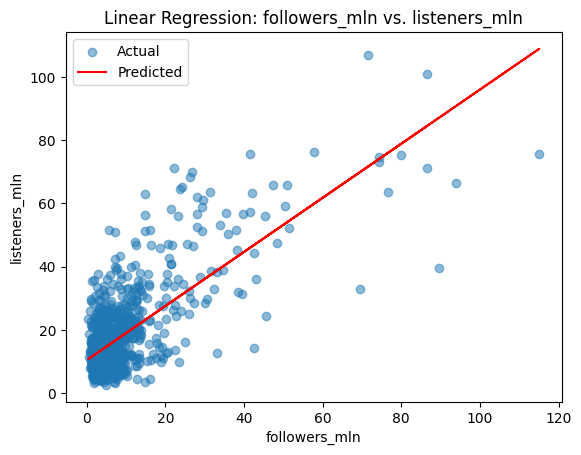

Intercept: 10.389
Coefficient: 0.8562
Correlation: 0.7236


In [15]:
model = LinearRegression()

X = df_merged[['followers_mln']]
y = df_merged['listeners_mln']
model.fit(X, y)

predictions = model.predict(X)

plt.scatter(X, y, label='Actual', alpha=0.5)
plt.plot(X, predictions, color='red', label='Predicted')
plt.xlabel('followers_mln')
plt.ylabel('listeners_mln')
plt.title('Linear Regression: followers_mln vs. listeners_mln')
plt.legend()
plt.show()

print(f'Intercept: {model.intercept_.round(4)}')
print(f'Coefficient: {model.coef_[0].round(4)}')

correlation = df_merged['followers_mln'].corr(df_merged['listeners_mln'])
print(f'Correlation: {correlation.round(4)}')

Fit a linear regression model to the relationship between number of followers and scoring, and plot the results with correlation coefficient

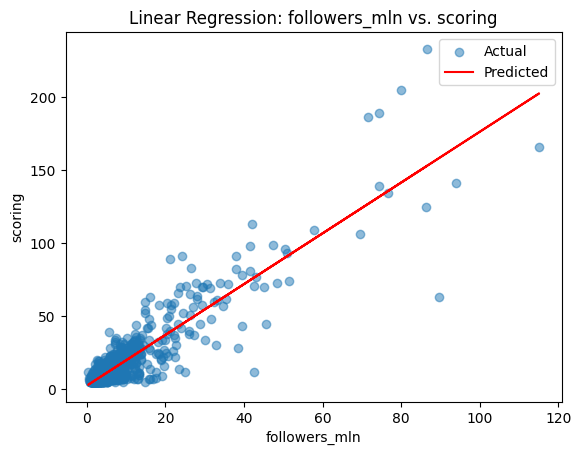

Intercept: 2.3848
Coefficient: 1.7384
Correlation: 0.8994


In [16]:
model = LinearRegression()

X = df_merged[['followers_mln']]
y = df_merged['scoring']
model.fit(X, y)

predictions = model.predict(X)

plt.scatter(X, y, label='Actual', alpha=0.5)
plt.plot(X, predictions, color='red', label='Predicted')
plt.xlabel('followers_mln')
plt.ylabel('scoring')
plt.title('Linear Regression: followers_mln vs. scoring')
plt.legend()
plt.show()

print(f'Intercept: {model.intercept_.round(4)}')
print(f'Coefficient: {model.coef_[0].round(4)}')

correlation = df_merged['followers_mln'].corr(df_merged['scoring'])
print(f'Correlation: {correlation.round(4)}')

Insights

* The top 1% of artists with the most followers includes globally recognized names such as Ed Sheeran, Ariana Grande, Billie Eilish, and Taylor Swift.
* The top 1% of artists with the most listeners includes artists like The Weeknd, Taylor Swift, Dua Lipa, and Ed Sheeran.
* Interestingly, some artists like Taylor Swift have significantly more followers (85.93 million) than listeners (100.93 million), similarly, Ed Sheeran has more followers (114.97 million) than listeners (76.19 million).


Correlations

* There is a positive correlation between followers and listeners, but it is not perfect. This means that artists with more followers tend to have more listeners, but there are also cases of artists with more followers than listeners and vice versa.
* Some artists have more followers than listeners because they are very popular on social media, but their music is not as widely listened to. Other artists have more listeners than followers because their music is very popular, but they are not as active on social media.

Actionable Recommendations

* Artists with more followers than listeners should focus on engaging with their audience on social media and encouraging them to listen to their music.
* Artists with more listeners than followers should focus on building their social media presence and connecting with their fans.
***

### Analyze the distribution of artists by album count and generate visualizations to understand the trends

In [17]:
# Group by 'artist' and count the number of albums

df_merged.sort_values(by='album_count', ascending=False).loc[:,['artist', 'album_count']].head(10)

,artist,album_count
929,Frédéric Chopin,726
798,Wolfgang Amadeus Mozart,615
643,S. P. Balasubrahmanyam,443
123,A.R. Rahman,226
787,Ella Fitzgerald,156
771,Louis Armstrong,150
288,Gucci Mane,141
544,Lata Mangeshkar,133
633,Kumar Sanu,133
386,Johnny Cash,118


In [19]:
# Filter artists with more than 1 album_count
filtered_df = df_merged[artist_album_counts['album_count'] > 1]

# Create a Histogram
histogram_fig = go.Figure(data=[
    go.Histogram(
        x=filtered_df['album_count'],
        nbinsx=500,
        marker_color='blue',)])

histogram_fig.update_layout(
    title='Distribution of Artists by Albums Count (more than 1 Albums)',
    xaxis=dict(title='Albums Count Range'),
    yaxis=dict(title='Number of Artists'),
    showlegend=False,
    bargap=0.1)

histogram_fig.show()

folder_name = 'graphs'
html_file = os.path.join(folder_name, 'album_count_range.html')

if not os.path.exists(folder_name):
    os.makedirs(folder_name)

# Check if the HTML file already exists
if not os.path.exists(html_file):
    pio.write_html(histogram_fig, file=html_file)
    print(f'HTML file "{html_file}" has been saved.')
else:
    print(f'HTML file "{html_file}" already exists.')

C:\Users\dovil\AppData\Local\Temp\ipykernel_5696\150687743.py:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



HTML file "graphs\album_count_range.html" has been saved.


In [20]:
# Clean the artist names to remove special characters
df_merged['cleaned_artist'] = df_merged['artist'].str.replace('[$]', 'S', regex=True)

# Filter artists with more than 50 album_count
df_filtered_50 = df_merged[df_merged['album_count'] > 50]

df_filtered_50 = df_filtered_50[df_filtered_50['cleaned_artist'].isin(df_merged['artist'])]

fig = px.bar(df_filtered_50, x='cleaned_artist', y='album_count',
             labels={'cleaned_artist': 'Artist', 'album_count': 'Album Count'},
             title='Album Counts by Artist (more than 50 Albums)')
fig.update_xaxes(categoryorder='total descending')
fig.update_layout(xaxis_tickangle=-45)
fig.show()

folder_name = 'graphs'
html_file = os.path.join(folder_name, 'album_counts.html')

if not os.path.exists(folder_name):
    os.makedirs(folder_name)

# Check if the HTML file already exists
if not os.path.exists(html_file):
    pio.write_html(histogram_fig, file=html_file)
    print(f'HTML file "{html_file}" has been saved.')
else:
    print(f'HTML file "{html_file}" already exists.')

HTML file "graphs\album_counts.html" has been saved.


In [21]:
fig = px.treemap(
    df_filtered_50,
    path=['cleaned_artist'],
    values='album_count',
    custom_data=['cleaned_artist', 'album_count'])


fig.update_traces(
    hovertemplate='<b>Artist:</b> %{customdata[0]}<br><b>Album Count:</b> %{customdata[1]}<br>')

fig.update_layout(
    title='Treemap of Album Counts by Artist',
    margin=dict(l=0, r=0, b=0, t=30))

fig.show()

folder_name = 'graphs'
html_file = os.path.join(folder_name, 'treemap.html')

if not os.path.exists(folder_name):
    os.makedirs(folder_name)

# Check if the HTML file already exists
if not os.path.exists(html_file):
    pio.write_html(histogram_fig, file=html_file)
    print(f'HTML file "{html_file}" has been saved.')
else:
    print(f'HTML file "{html_file}" already exists.')

HTML file "graphs\treemap.html" has been saved.


The: 2062
Deluxe: 959
Live: 875
Edition: 837
Vol: 699
Original: 566
Soundtrack: 510
Piano: 467
Motion: 463
Picture: 463
Mozart:: 458
Chopin:: 447
of: 417
the: 409
A: 392
0: 369
In: 333
Of: 328
Remastered: 289
Vivo: 272


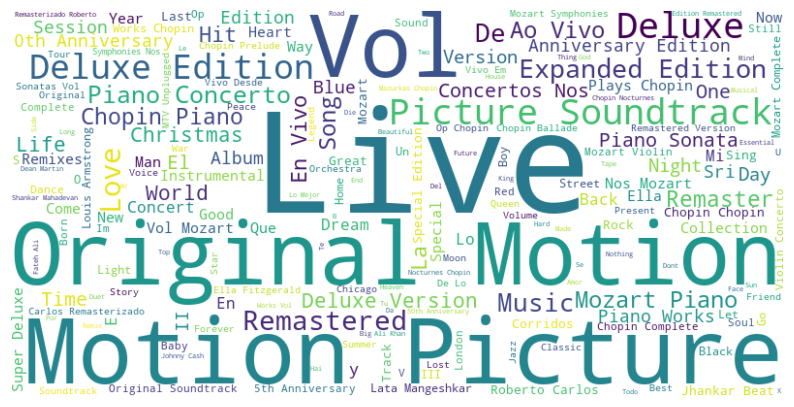

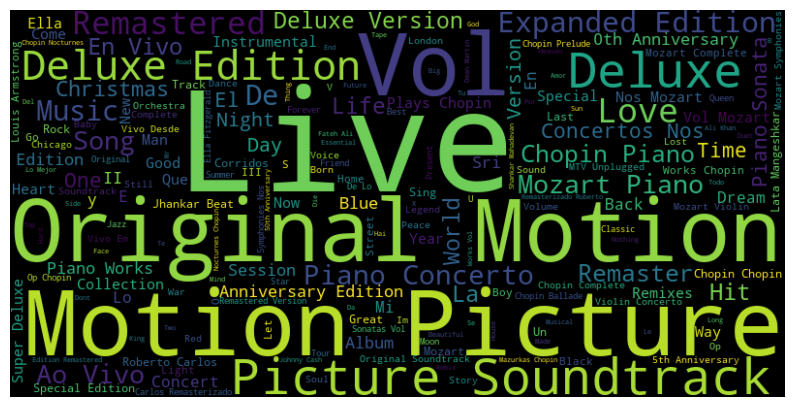

In [ ]:
# Function to generate and display a word cloud
def generate_wordcloud(text, background_color):
    wordcloud = WordCloud(width=800, height=400, background_color=background_color).generate(text)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

# Concatenate all album_names into a single string
all_album_names = ' '.join(df_albums['album_name'].astype(str))
words_to_remove = ['feat', 'remix', 'ft', 'ft.', "'", '.', '-', '&', '[', ']', '(', ')','1', '2','3', '4']
for word in words_to_remove:
    all_album_names = all_album_names.replace(word, "")

word_counts = Counter(all_album_names.split())
sorted_word_counts = dict(sorted(word_counts.items(), key=lambda item: item[1], reverse=True))
top_20_words = dict(list(sorted_word_counts.items())[:20])
for word, count in top_20_words.items():
    print(f'{word}: {count}')

# Generate and display the word cloud
generate_wordcloud(all_album_names, 'white')
generate_wordcloud(all_album_names, 'black')

Top Artists and Their Popular Albums:

* The top 3  music artists by album count are Frédéric Chopin (726 albums), Wolfgang Amadeus Mozart (615 albums), and S. P. Balasubrahmanyam (443 albums). 
* It is interesting that the first two artists by number of albums are classical musicians. This data suggests that classical music is highly valued and that there is a large and dedicated audience for this genre of music.
* The most common words in album names are articles and prepositions, such as "The", "Of", "In", and "And". These words are often used to describe the contents of the album, such as the artist, genre, or theme. Other common words include "Live", "Original", "Soundtrack", and "Piano", which describe the type of music on the album.
* The names of composers and musicians are also common in album names, such as "Mozart", "Chopin", and "Elvis". This suggests that many people look for albums by their favorite artists, or that albums featuring the work of famous composers are popular.